In [2]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import contextily as cx
import descartes

# Data curation
## Importing and wrangling spatial data

<AxesSubplot:>

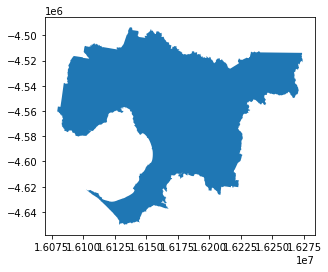

In [78]:
basemap = geopandas.read_file("land.geojson")
basemap = basemap.to_crs(epsg=3857)
basemap.plot()

In [3]:
data = geopandas.read_file("metro-data2.geojson")
sdf = geopandas.GeoDataFrame(data)

#Select only the columns of interest
sdf = sdf[['HMGNS_LNK_', 'geometry']]

#Change projection and rename a column
sdf = sdf.to_crs(epsg=7899)
sdf.columns = ["HMGNS_LNK_ID", "geometry"]

#Lines have duplicates (each for 2 sides of the road) - we're keeping only one
sdf = sdf.drop_duplicates(subset="HMGNS_LNK_ID", keep="first")

#sort by ID
sdf = sdf.sort_values("HMGNS_LNK_ID")
print(sdf.head(30))

      HMGNS_LNK_ID                                           geometry
179              2  MULTILINESTRING ((2512268.212 2400819.746, 251...
547              9  MULTILINESTRING ((2521723.707 2398784.886, 252...
2813            25  MULTILINESTRING ((2497597.919 2404263.059, 249...
363             28  MULTILINESTRING ((2490757.167 2406179.544, 249...
327             30  MULTILINESTRING ((2502286.062 2399884.413, 250...
685             31  MULTILINESTRING ((2502043.455 2398283.407, 250...
4338            32  MULTILINESTRING ((2493520.830 2418370.324, 249...
4822            33  MULTILINESTRING ((2493691.033 2418295.999, 249...
4023            34  MULTILINESTRING ((2493757.061 2418266.132, 249...
3403            35  MULTILINESTRING ((2493801.064 2418247.008, 249...
3493            36  MULTILINESTRING ((2494058.745 2418144.526, 249...
364             37  MULTILINESTRING ((2480071.228 2413653.552, 248...
328             38  MULTILINESTRING ((2517332.679 2416838.056, 251...
686             39  

## Importing and cleaning data on traffic volume

In [4]:
dataset = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')
dataset = dataset.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE'], axis=1)
dataset = dataset[dataset['PERIOD_TYPE']=='SCHOOL TERM/NORMAL']

dataset = dataset.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
dataset = dataset.drop(['PERIOD_TYPE'], axis=1)
dataset = dataset.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=dataset.iloc[:,2:27], var_name='Hour', value_name='Value')
dataset['Hour'] = pd.to_numeric(dataset['Hour'])
dataset = dataset.drop_duplicates(subset=["HMGNS_LNK_ID",'DOW','Hour'], keep="first")

dataset = dataset.sort_values(["HMGNS_LNK_ID",'DOW','Hour'])

#Normalising the traffic volume between 0 and 3 in order to plot it as linewidth
dataset['Normalised Value']=(dataset['Value']-dataset['Value'].min())/(dataset['Value'].max()-dataset['Value'].min())
dataset['Normalised Value']=4*dataset['Normalised Value']
print(dataset.head(25))

         HMGNS_LNK_ID  DOW  Hour  Value  Normalised Value
1974                2    1     0    886          0.326756
77023               2    1     1    489          0.180343
152072              2    1     2    335          0.123548
227121              2    1     3    317          0.116909
302170              2    1     4    468          0.172598
377219              2    1     5   1144          0.421907
452268              2    1     6   3177          1.171676
527317              2    1     7   5536          2.041674
602366              2    1     8   6322          2.331551
677415              2    1     9   4746          1.750323
752464              2    1    10   4434          1.635257
827513              2    1    11   4645          1.713074
902562              2    1    12   4985          1.838466
977611              2    1    13   5268          1.942836
1052660             2    1    14   6304          2.324912
1127709             2    1    15   7895          2.911673
1202758       

## Further wrangling of the traffic data

In [5]:
#Old version
#hourly = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')

#Dropping columns of no interest
#hourly_dropped = hourly.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE', 'PERIOD_TYPE'], axis=1)

#Renaming the 'hours' columns to be able to sort them from 0 to 23
#hourly_dropped = hourly_dropped.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")

#Melting the data to make it long
#hourly_long = hourly_dropped.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=hourly_dropped.iloc[:,2:27], var_name='Hour', value_name='Value')
#hourly_long['Hour'] = pd.to_numeric(hourly_long['Hour'])
#sorted_df = hourly_long.sort_values(['HMGNS_LNK_ID','DOW','Hour'])
#print(sorted_df.head(5))
#Grouping by: road ID, Day of week and Hour and calculating average value of traffic volume for each
#grouped_multiple = hourly_long.groupby(['HMGNS_LNK_ID', 'DOW', 'Hour']).agg({'Value': 'mean'})
#grouped_multiple.columns = ['Average Value']
#grouped_multiple = grouped_multiple.reset_index()
#Sorting by Road ID, Day of week and Hour
#sorted_df = grouped_multiple.sort_values(["HMGNS_LNK_ID"])
#print(sorted_df.head(170))

### Combining spatial data with the traffic volume data by road ID


In [6]:
sdf = sdf.to_crs(epsg=3857)
df = sdf.merge(dataset, on="HMGNS_LNK_ID", how="right")
print(df.head(25))


    HMGNS_LNK_ID                                           geometry  DOW  \
0              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
1              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
2              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
3              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
4              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
5              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
6              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
7              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
8              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
9              2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
10             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
11             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1   
12          

# Plotting

In [7]:
#Sorting by Road ID, Day of week and Hour
df = df.sort_values(["HMGNS_LNK_ID", 'DOW', 'Hour'])

print(df.head())

   HMGNS_LNK_ID                                           geometry  DOW  Hour  \
0             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     0   
1             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     1   
2             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     2   
3             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     3   
4             2  MULTILINESTRING ((16156853.070 -4564412.550, 1...    1     4   

   Value  Normalised Value  
0    886          0.326756  
1    489          0.180343  
2    335          0.123548  
3    317          0.116909  
4    468          0.172598  


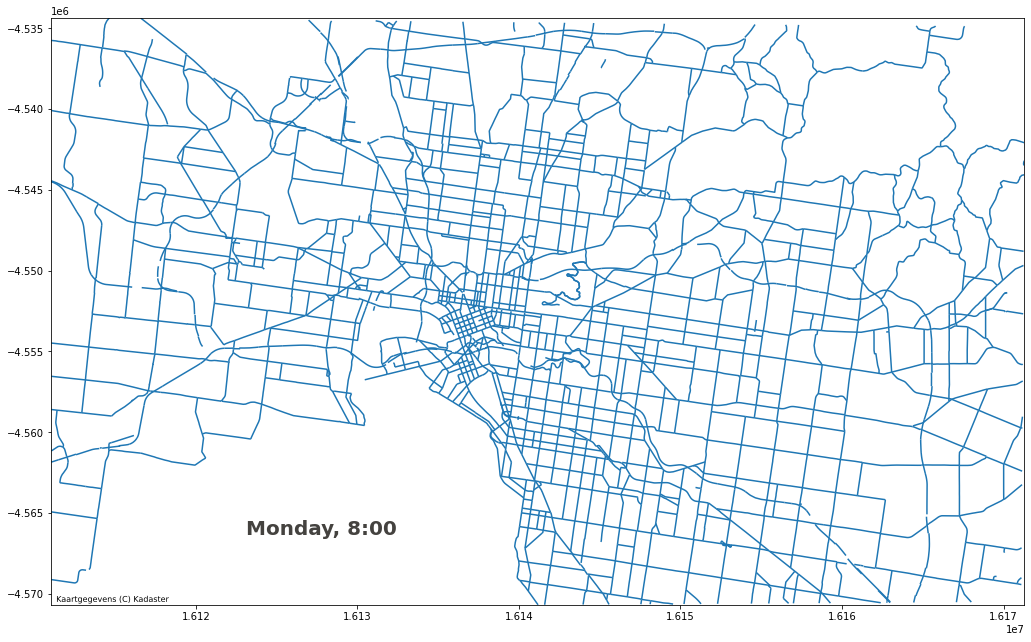

In [103]:
#for dow in df['DOW']:
 #   day_df = df[df['DOW']==dow]
 #   print("It is day ", dow)
  #  for hour in day_df['Hour']:
  #      #day_hour_df = df[df['Hour'] == hour]
  #      print("It is day ", dow, " and hour is ", hour)

fig, ax = plt.subplots(1,figsize=(19.2, 10.8))
ax.margins(0.0,0.0)
sdf.plot(ax=ax)
#cx.add_basemap(ax, source=cx.providers.nlmaps.grijs)
plt.annotate('Monday, 8:00', xy=(0.2, 0.12), xycoords='axes fraction', c="#44423f", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
plt.show()

In [58]:
days_ow = {1:'Monday', 2: 'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
print(days_ow[5])

Friday


Doing dow=1, hour=0
Doing dow=1, hour=1
Doing dow=1, hour=2
Doing dow=1, hour=3
Doing dow=1, hour=4
Doing dow=1, hour=5
Doing dow=1, hour=6
Doing dow=1, hour=7
Doing dow=1, hour=8
Doing dow=1, hour=9
Doing dow=1, hour=10
Doing dow=1, hour=11
Doing dow=1, hour=12
Doing dow=1, hour=13
Doing dow=1, hour=14
Doing dow=1, hour=15
Doing dow=1, hour=16
Doing dow=1, hour=17
Doing dow=1, hour=18
Doing dow=1, hour=19


KeyboardInterrupt: 

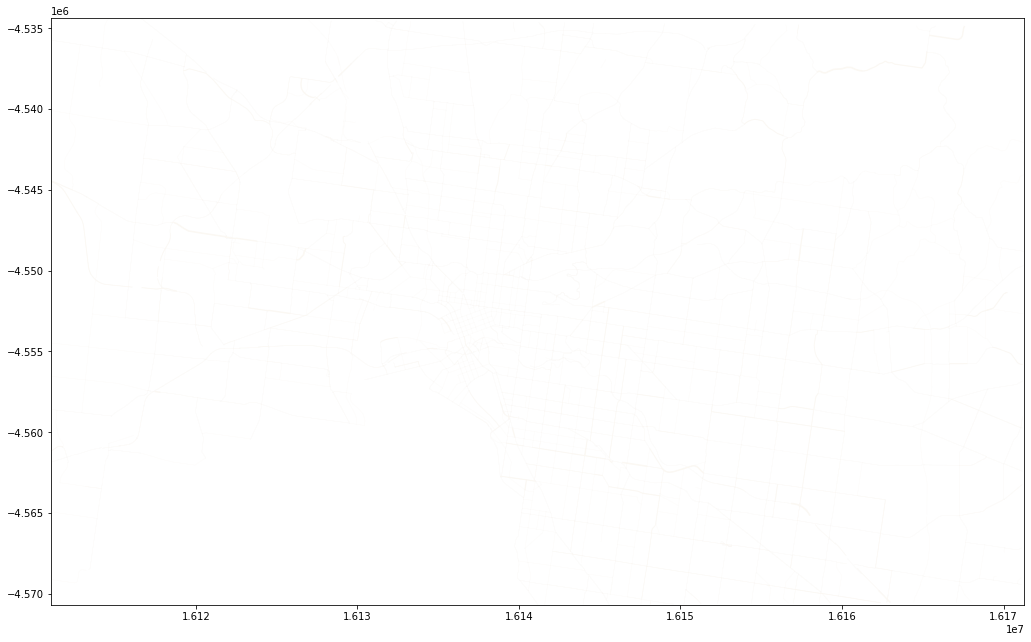

In [105]:
for dow, day_gdf in df.groupby("DOW"):
    today = days_ow[dow]
    for hour, day_hour_gdf in day_gdf.groupby("Hour"):
        #fig, ax = plt.subplots(1)
        fig, ax = plt.subplots(1, figsize=(19.2, 10.8))
        ax.margins(0)
        print(f"Doing dow={dow}, hour={hour}")
        sdf.plot(ax=ax, linewidth=0.2, color = "#FBF8F3")
        day_hour_gdf.plot(ax=ax, linewidth=day_hour_gdf['Normalised Value'], color = "#FBF8F3")
        plt.annotate("{}, {}:00".format(today, hour), xy=(0.2, 0.12), xycoords='axes fraction', c="#e0d8cc", fontfamily="sans-serif", fontsize=20, weight = 'semibold')
        plt.axis('off')
        plt.savefig("day{}_hour{}.png".format(dow, hour), dpi = 300, facecolor='#44423f', bbox_inches='tight')
        plt.close()

### Basemaps

In [101]:
print(cx.providers.keys())
print(cx.providers.nlmaps.keys())

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])
dict_keys(['standaard', 'pastel', 'grijs', 'luchtfoto'])


In [ ]:
plot